# Trabalho Prático 1: Compressão de Imagens

### Carlos Henrique Brito Malta Leão - 2021039794
### Vinícius Alves de Faria Resende - 2021039972

#### Importação de Bibliotecas

In [1160]:
import os
import cv2
import struct
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
from heapq import heappush, heappop, heapify
from collections import defaultdict

#### Funções e Constantes

Nesta etapa é definida a imagem a ser comprimida, então esta imagem é lida e armazenada para ser usada por toda a extensão do código.

In [1161]:
IMAGE_PATH = 'lena512.pgm'

original_img = cv2.imread(IMAGE_PATH,0)
size = original_img.shape

**Matriz de Quantização**

Este algoritmo utiliza a técnica DCT, o qual baseia-se, entre outras coisas, em uma matriz de quantização. Portando, escolhemos uma matriz de quantização 8x8 padrão da compressão JPEG, também apresentada pelo professor. Desta maneira, evita-se a necessidade de salvar a matriz no cabeçalho, ao mesmo tempo faz-se a escolha de uma matriz que foi desenvolvida e "lapidada" a partir de muitos testes empíricos."

Ademais, é feito um "scaling" dos valores, de forma a aumentar a taxa de compressão "sacrificando" parte da qualidade da imagem. Testamos alguns valores e avaliamos o resultado da taxa de compressão e a métrica PSNR, por fim, decidimos que diferentes tamanhos de imagem demandavam diferentes "scalings". Dessa forma, optamos por desenvolver um "scaling" dinâmico em relação ao tamanho da imagem de entrada, tomando como base uma imagem de 512x512 com "scaling" de 1.2.

In [1162]:
"""
This code defines and initializes a quantization matrix (QM) used in image compression algorithms, such as JPEG.

Attributes:
	QM (numpy.matrix): An 8x8 matrix containing quantization values. These values are used to reduce the precision of the DCT coefficients during the quantization step in image compression.

The quantization matrix is converted to a float type to ensure that subsequent operations involving this matrix are performed with floating-point precision.
"""
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61],
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

base_scale_factor = 1.0
scale_increment = 0.2
reference_size = 512 * 512
image_area = size[0] * size[1]
scale_factor = base_scale_factor + scale_increment * (image_area / reference_size)
QM *= scale_factor

QM = QM.astype(float)

print("Quantization matrix:", QM)
print("Scale factor:", scale_factor)

Quantization matrix: [[ 19.  13.  12.  19.  28.  48.  61.  73.]
 [ 14.  14.  16.  22.  31.  69.  72.  66.]
 [ 16.  15.  19.  28.  48.  68.  82.  67.]
 [ 16.  20.  26.  34.  61. 104.  96.  74.]
 [ 21.  26.  44.  67.  81. 130. 123.  92.]
 [ 28.  42.  66.  76.  97. 124. 135. 110.]
 [ 58.  76.  93. 104. 123. 145. 144. 121.]
 [ 86. 110. 114. 117. 134. 120. 123. 118.]]
Scale factor: 1.2


**Obtenção do DCT para imagem 2D**

Essa função aceita uma matriz no domínio da imagem e, através da transformada discreta dos cossenos (DCT), a converte para o domínio da frequência. A DCT foi selecionada para executar essa transformação em vez da Fourier, pois esta última produz uma resposta em números complexos, ocasionando na necessidade de salvar muitos valores, prejudicando a compressão.

In [1163]:
def get_2D_dct(img):
	"""
	Get the 2D Discrete Cosine Transform (DCT) of an image.

	Parameters:
	img (ndarray): Input image array.

	Returns:
	ndarray: The 2D DCT of the input image.
	"""
	return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

**Obtenção da inversa do DCT para imagem 2D**

Considerando os coeficientes após a aplicação do DCT em uma imagem, a função abaixo é capaz de invertê-los para obter a imagem original. Isso é feito por meio da aplicação da transformada inversa do DCT, i.e., IDCT.

In [1164]:
def get_2d_idct(coefficients):
	"""
	Compute the 2D Inverse Discrete Cosine Transform (IDCT) of the given coefficients.

	Parameters:
	coefficients (ndarray): A 2D array of DCT coefficients.

	Returns:
	ndarray: A 2D array representing the spatial domain image obtained after applying the IDCT.
	"""
	return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

**Funcoes de qualidade da compressão**

**RMSE**

O RMSE (Erro Médio Quadrado) representa a soma do erro entre os pixels (x,y) da imagem original e os pixels (x,y) da imagem modificada, dividido pelo tamanho da matriz. Esta métrica avalia a média de desvio dos pixels da sua imagem em relação ao valor original. Por levar em conta o erro quadrático, os pixels com diferenças mais acentuadas tendem a ter maior influência no resultado da métrica.

In [1165]:
def rmse(predictions, targets):
	"""
	Calculate the Root Mean Square Error (RMSE) between predictions and targets.

	Parameters:
	predictions (array-like): The predicted values.
	targets (array-like): The actual values.

	Returns:
	float: The RMSE value.
	"""
	return np.sqrt(((predictions - targets) ** 2).mean())

**PSNR**

O PSNR (Peak Signal-to-Noise Ratio, ou Razão de Pico de Sinal para Ruído) é uma métrica amplamente utilizada para avaliar a qualidade de uma imagem ou vídeo comprimido em comparação com o original. Ele mede o nível de degradação causado pela compressão ou por outros tipos de processamento, como ruídos ou filtros.

In [1166]:
def psnr(predictions, targets):
	"""
	Calculate the Peak Signal-to-Noise Ratio (PSNR) between two images.

	PSNR is an approximation to human perception of reconstruction quality.
	Higher PSNR generally indicates that the reconstruction is of higher quality.

	Parameters:
	predictions (numpy.ndarray): The predicted image data.
	targets (numpy.ndarray): The target (ground truth) image data.

	Returns:
	float: The PSNR value in decibels (dB).

	Raises:
	ValueError: If the input arrays do not have the same shape.
	"""
	if predictions.shape != targets.shape:
		raise ValueError("Input arrays must have the same shape.")
	rmsev = rmse(predictions, targets)
	return 20 * np.log10(255/rmsev)

**Cálculo de Entropia**

O cálculo de entropia é fundamental na compressão de imagens, pois mede a quantidade média de informação contida nos pixels, avaliando a redundância dos dados. Uma imagem com alta entropia possui mais variação e é menos redundante, dificultando a compressão, enquanto uma imagem com baixa entropia contém padrões repetitivos ou áreas uniformes, que podem ser mais eficientemente representadas por algoritmos de compressão. Essa análise permite identificar o limite teórico de compressão sem perda e orientar a escolha ou otimização de métodos, como codificação Huffman ou aritmética, para reduzir o tamanho do arquivo mantendo a qualidade visual.

In [1167]:
def calc_entropy(img):
	"""
	Calculate the entropy of an image.

	Entropy is a measure of the randomness or disorder of the pixel values in the image.
	This function computes the entropy based on the histogram of the image.

	Parameters:
	img (numpy.ndarray): Input image in grayscale.

	Returns:
	float: Entropy value of the image.
	"""
	hist = cv2.calcHist([img],[0],None,[256],[0,256])
	hist = hist.ravel()/hist.sum()
	logs = np.log2(hist+0.00001)
	entropy = -1 * (hist*logs).sum()

	return entropy

**Filtro Gaussiano**

O kernel Gaussiano gerado pela função acima é uma matriz bidimensional que aplica uma filtragem suavizadora em imagens. Ele é construído com base na fórmula da distribuição Gaussiana, calculando valores que decaem exponencialmente à medida que se afastam do centro do kernel, definido pelo parâmetro `sigma`, que controla a intensidade da suavização. A normalização garante que a soma dos elementos seja 1, preservando a intensidade total da imagem após o filtro.

No contexto de compressão de imagens, o kernel Gaussiano é importante porque reduz ruídos e elimina detalhes irrelevantes, tornando a imagem mais homogênea. Isso ajuda algoritmos de compressão a melhor identificarem padrões redundantes e alcançarem taxas de compressão mais altas, como nos formatos JPEG, onde a suavização prévia facilita a quantização e a codificação em blocos DCT (Transformada Discreta do Cosseno).

In [1168]:
def gaussian_kernel(size, sigma):
	"""
	Generates a Gaussian kernel.

	Parameters:
	size (int): The size of the kernel. It should be an odd number.
	sigma (float): The standard deviation of the Gaussian distribution.

	Returns:
	numpy.ndarray: A 2D array representing the Gaussian kernel.
	"""
	kernel = np.zeros((size, size), dtype=float)
	offset = size // 2 # Calculate the offset to the center of the kernel

  # Fill kernel with Gaussian values
	for x in range(-offset, offset + 1):
		for y in range(-offset, offset + 1):
			kernel[x + offset, y + offset] = (1 / (2 * np.pi * sigma**2)) * np.exp(-(x**2 + y**2) / (2 * sigma**2))

	# Normalize the kernel so the values sum to 1
	kernel /= kernel.sum()
	return kernel

A função `apply_gaussian_filter` aplica um filtro Gaussiano a uma imagem por meio de convolução, utilizando um kernel fornecido. Para cada pixel da imagem, a função extrai uma região correspondente ao tamanho do kernel, calcula o produto elemento a elemento entre a região e o kernel, e armazena a soma desse produto na posição correspondente de uma nova imagem suavizada. Essa abordagem suaviza a imagem ao reduzir variações bruscas nos valores de intensidade, eliminando ruídos e preparando a imagem para tarefas como compressão, segmentação ou realce de bordas.

In [1169]:
def apply_gaussian_filter(image, kernel):
	"""
	Apply a Gaussian filter to an image.

	Parameters:
	image (numpy.ndarray): The input image to be smoothed.
	kernel (numpy.ndarray): The Gaussian kernel to be applied.

	Returns:
	numpy.ndarray: The smoothed image after applying the Gaussian filter.
	"""
	img_h, img_w = image.shape
	k_h, k_w = kernel.shape
	offset_h, offset_w = k_h // 2, k_w // 2

	# Create an empty image to store the smoothed image
	smoothed_image = np.zeros_like(image, dtype=float)

	# Apply the Gaussian filter to the image
	for i in range(offset_h, img_h - offset_h):
		for j in range(offset_w, img_w - offset_w):
			region = image[i - offset_h:i + offset_h + 1, j - offset_w:j + offset_w + 1]
			smoothed_image[i, j] = np.sum(region * kernel)

	return smoothed_image



**Codificação de Huffman**

A função `encode` implementa a codificação de Huffman, que é um algoritmo de compressão de dados sem perdas. Dada uma tabela que mapeia símbolos a suas frequências, a função constrói uma árvore de Huffman usando uma fila de prioridade (heap). Os símbolos com maior frequência recebem códigos binários mais curtos, enquanto os menos frequentes recebem códigos mais longos. O resultado é uma lista de tuplas contendo cada símbolo e seu código binário correspondente, ordenados pelo comprimento do código e, posteriormente, pelo símbolo.

A codificação de Huffman é essencial para a compressão de imagens porque reduz o tamanho do arquivo ao explorar a redundância nos dados, atribuindo representações mais eficientes aos símbolos mais comuns. Em formatos como JPEG, ela é usada após a quantização para comprimir os coeficientes da imagem de forma compacta e eficiente, garantindo menor perda de qualidade e reduzindo significativamente o espaço de armazenamento.

In [1170]:
def encode(symb2freq):
	"""
	Huffman encode the given dictionary mapping symbols to weights.

	This function takes a dictionary where keys are symbols and values are their corresponding weights (frequencies).
	It returns a list of tuples where each tuple contains a symbol and its corresponding Huffman code.

	Parameters:
	symb2freq (dict): A dictionary mapping symbols to their weights (frequencies).

	Returns:
	list: A list of tuples, each containing a symbol and its corresponding Huffman code, sorted by the length of the code and then by the symbol.
	"""
	# Create a priority queue to store the heap
	heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
	heapify(heap)

	# Merge nodes to create the Huffman tree
	while len(heap) > 1:
		lo = heappop(heap)
		hi = heappop(heap)
		for pair in lo[1:]:
			pair[1] = '0' + pair[1]
		for pair in hi[1:]:
			pair[1] = '1' + pair[1]
		heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])

	# Return the sorted list of symbols and their Huffman codes
	return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))

A função `calc_hist` é crucial para a codificação de Huffman, pois calcula o histograma dos valores em um array, determinando a frequência normalizada de cada símbolo presente. Essa análise é o primeiro passo para a construção da árvore de Huffman, já que a codificação depende diretamente da frequência de ocorrência dos símbolos para gerar códigos binários mais curtos para os mais frequentes e mais longos para os menos frequentes. Ao organizar os símbolos com base em suas frequências, a função prepara os dados para serem processados de forma eficiente no algoritmo de Huffman, otimizando a compressão de imagens ao reduzir a redundância dos dados.

In [1171]:
def calc_hist(numpy_array):
	"""
	Calculate the histogram of values in a numpy array.

	Args:
		numpy_array (numpy.ndarray): The input array for which the histogram is to be calculated.

	Returns:
		list of tuples: A list of tuples where each tuple contains a value from the array and its
						normalized frequency, sorted in descending order of frequency.
	"""
	length = len(numpy_array)

	hist = {}
	for value in numpy_array:
		if value in hist:
			hist[value] += 1
		else:
			hist[value] = 1

	# Convert the histogram to a list of tuples and normalize the frequencies
	hist_list = [(value, freq / length) for value, freq in hist.items()]

	hist_list.sort(key=lambda x: -x[1])

	return hist_list

**Conversão String <-> Binário**

A função `binary_string_to_real_binary` converte uma string binária (composta de `0`s e `1`s) em uma representação binária real no formato de bytes, otimizando o armazenamento em arquivos. Para isso, ela ajusta o comprimento da string para ser múltiplo de 8, adicionando zeros à esquerda se necessário, e converte a string ajustada para um objeto de bytes usando a base binária. Além disso, a função retorna o comprimento original da string binária, permitindo que o dado possa ser restaurado com precisão posteriormente. Essa abordagem é eficiente em termos de espaço, pois reduz o uso de armazenamento comparado à manipulação direta da string binária, sendo especialmente útil para aplicações como compressão de dados ou armazenamento de códigos de Huffman em arquivos.

In [1172]:
def binary_string_to_real_binary(binary_string):
	"""
	Converts a binary string to real binary (bytes).
	"""
	# Ensure the binary string length is a multiple of 8
	padded_length = (len(binary_string) + 7) // 8 * 8
	padded_binary_string = binary_string.zfill(padded_length)  # Add leading zeros if needed

	# Convert to bytes
	byte_array = int(padded_binary_string, 2).to_bytes(len(padded_binary_string) // 8, byteorder='big')
	return byte_array, len(binary_string)  # Return the real binary and the original length

A função `real_binary_to_binary_string` reconverte uma representação binária em formato de bytes de volta para sua string binária original, garantindo a preservação exata do número de dígitos. Ela converte os bytes em um número inteiro, obtém a representação binária correspondente como string e remove o prefixo `0b`. Em seguida, ajusta o comprimento da string para corresponder ao comprimento original fornecido, adicionando zeros à esquerda quando necessário. Essa função é essencial para restaurar dados previamente convertidos para o formato binário real, garantindo precisão na reconstrução de informações, como em sistemas de compressão que utilizam códigos binários otimizados, como a codificação de Huffman.

In [1173]:
def real_binary_to_binary_string(real_binary, original_length):
	"""
	Converts real binary (bytes) back to the original binary string.
	"""
	# Convert bytes back to a binary string
	binary_string = bin(int.from_bytes(real_binary, byteorder='big'))[2:]  # Strip "0b"

	# Trim any padding to match the original length
	return binary_string.zfill(original_length)  # Add leading zeros if needed

#### Algoritmo de Compressão

**Aplicação de Filtro Gaussiano**

A seção abaixo faz a aplicação de um filtro gaussiano na imagem, de forma a reduzir sua entropia e auxiliar no processo de compressão. Testamos esta estratégia e ela de fato funcionou, contudo, os resultados foram desproporcionais e não atingiram as expectativas. Isto se deu ao fato de que a perda de qualidade da imagem registrada pelo PSNR era muito maior do que a melhora na Taxa de Compressão obtida, portanto, para as imagens de teste disponibilizadas, não houve ganho significativo que justificasse a aplicação desta metodologia. Contudo, com propósito de documentação a mantivemos aqui.

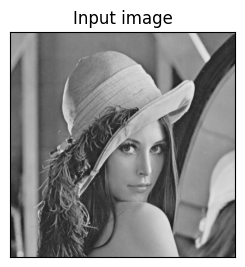

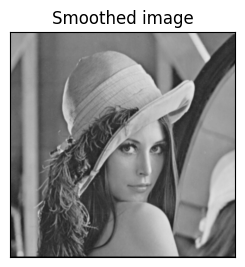

7.442465782165527
7.417585372924805


In [1174]:
smoothed_img = apply_gaussian_filter(original_img, gaussian_kernel(3, 1))

plt.subplot(121),plt.imshow(original_img, cmap = 'gray', clim=(0, 255))
plt.title('Input image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(smoothed_img, cmap = 'gray', clim=(0, 255))
plt.title('Smoothed image'), plt.xticks([]), plt.yticks([])
plt.show()

print(calc_entropy(original_img.astype(np.uint8)))
print(calc_entropy(smoothed_img.astype(np.uint8)))

img = smoothed_img

**Inicialização de variávies relevantes ao processo DCT**

In [1175]:
img = original_img # Esta linha seria removida no caso de usar a imagem suavizada (Gaussiana)

# Converts original image to float so that DCT does not lose information
img = img.astype(float)
step = 8

O código a seguir tem como objetivo ajustar as dimensões de uma imagem para garantir que ela seja quadrada e que seus lados sejam múltiplos de 8. Esse procedimento é necessário quando trabalhamos com algoritmos de compressão de imagens, como a Transformada Discreta de Cosseno (DCT), que opera em blocos 8x8. Caso a imagem original não tenha dimensões múltiplas de 8, a função aplica padding (preenchimento) para garantir que as dimensões da imagem se ajustem adequadamente, permitindo que a DCT seja aplicada sem problemas. A função retorna a imagem ajustada e suas novas dimensões, possibilitando a continuidade do processamento da imagem para compressão e outras operações.

In [1176]:
height, width = img.shape

pad_height = (8 - height % 8) % 8
pad_width = (8 - width % 8) % 8

img = np.pad(img, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

max_dimension = max(img.shape)
pad_height = max_dimension - img.shape[0]
pad_width = max_dimension - img.shape[1]

img = np.pad(img, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)

adjusted_img = img

size = img.shape

**Aplicação da Tabela de Quantização**

In [1177]:
DCT = np.zeros(size, dtype=float)

# Set print options for numpy arrays
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

useDC = True  # encode or not DC coefficient with DCT

# Normalize image to have zero mean and unit variance
img = img-128

# Apply DCT to image
for y in range(0,size[0],step):
	for x in range(0,size[1],step):
		dct = get_2D_dct(img[y:y+step, x:x+step])
		odct = dct
		DC = dct[0,0]

		dct = np.divide(dct, QM)
		dct = dct.round()
		coddct = dct

		dct = np.multiply(dct, QM)
		if (useDC == True):
			dct[0,0] = DC
		DCT[y:y+step, x:x+step] = dct

**Apresentação dos Resultados parciais do DCT**


Patch after DCT:
[[-327.75   -67.632  -19.507   -5.221    4.5      1.922    3.209    1.588]
 [ -84.677  -18.749    0.484   -3.446    2.369   -4.467   -3.287    4.002]
 [ -10.366    0.798   13.48    -3.958    8.747    6.865    1.055   -2.194]
 [  -8.972    1.699    0.932    1.137    0.425    4.757    2.217   -1.557]
 [  -6.5      6.031    1.752   -0.501   -1.25     2.652   -0.996   -3.117]
 [  -4.147    4.574    1.97    -1.253    0.838    0.555   -0.429   -1.904]
 [  -8.695   -3.441   -4.945    2.11     1.518   -4.112    2.52     2.46 ]
 [   2.747   -2.009   -0.988    1.571    3.825   -3.964    1.77     2.057]]

Patch to be coded:
[[-17.  -5.  -2.  -0.   0.   0.   0.   0.]
 [ -6.  -1.   0.  -0.   0.  -0.  -0.   0.]
 [ -1.   0.   1.  -0.   0.   0.   0.  -0.]
 [ -1.   0.   0.   0.   0.   0.   0.  -0.]
 [ -0.   0.   0.  -0.  -0.   0.  -0.  -0.]
 [ -0.   0.   0.  -0.   0.   0.  -0.  -0.]
 [ -0.  -0.  -0.   0.   0.  -0.   0.   0.]
 [  0.  -0.  -0.   0.   0.  -0.   0.   0.]]

Reconstructed p

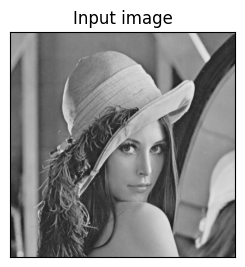

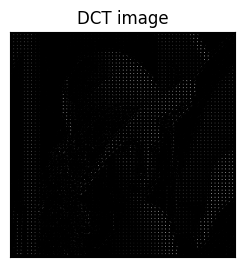

In [1178]:
print ("\nPatch after DCT:"  )
print (odct)

print ("\nPatch to be coded:")
print (coddct)

print ("\nReconstructed patch:")
print (dct )

img = img + 128

plt.subplot(121),plt.imshow(img, cmap = 'gray', clim=(0, 255))
plt.title('Input image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(DCT, cmap = 'gray', clim=(0, 255))
plt.title('DCT image'), plt.xticks([]), plt.yticks([])
plt.show()

**Arredondamento do DCT para Redução de Chaves no Huffman**

É definido um coeficiente de arredondamento para dividir a matriz DCT, o que reduz o número de chaves necessárias na codificação de Huffman, pois valores semelhantes são agrupados em um único valor. Após a divisão, os valores da matriz são arredondados para inteiros, eliminando as casas decimais. Em seguida, a matriz é multiplicada novamente pelo coeficiente de arredondamento, restaurando os valores para uma escala próxima da original, mas com menor precisão, o que contribui para uma maior eficiência na compressão.

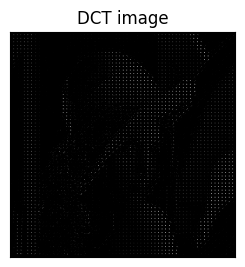

In [1179]:
rounding_coefficient = 20

DCT /= rounding_coefficient
DCT = np.round(DCT)
DCT *= rounding_coefficient

plt.subplot(121),plt.imshow(DCT, cmap = 'gray', clim=(0, 255))
plt.title('DCT image'), plt.xticks([]), plt.yticks([])
plt.show()

**Comparação de Entropias**

Após a aplicação do DCT, é feito o cálculo da entropia da imagem original e da matriz DCT de forma a compará-los. É possível notar abaixo uma diferença significativa, para o caso da imagem lena512, a entropia original era por volta de 7.44 e da matriz DCT é de 2.48. Essa redução na entropia beneficia a utilização de técnicas como o Algoritmo de Huffman, que será aplicado na seção seguinte.

In [1180]:
print(calc_entropy(img.astype(np.uint8)))
print(calc_entropy(DCT.astype(np.uint8)))

7.442465782165527
0.8264420032501221


**Cálculo do Histograma na Imagem DCT**

O código abaixo é responsável por utilizar a função `calc_hist` para obter a distribuição de probabilidade dos valores da matriz DCT. Essa etapa é essencial para aplicação do algoritmo de Huffman. Podemos notar que mais de 90% dos valores são 0, isso é um forte indicativo para uma boa compressão com a técnica de Huffman.

In [1181]:
hist = calc_hist(DCT.flatten())
print(hist)

[(0.0, 0.9017791748046875), (-20.0, 0.02703094482421875), (20.0, 0.025104522705078125), (-40.0, 0.007770538330078125), (40.0, 0.007747650146484375), (-60.0, 0.00356292724609375), (60.0, 0.003467559814453125), (-80.0, 0.00202178955078125), (80.0, 0.001934051513671875), (100.0, 0.00130462646484375), (120.0, 0.0012054443359375), (-100.0, 0.00116729736328125), (-120.0, 0.001064300537109375), (160.0, 0.00077056884765625), (140.0, 0.000759124755859375), (-160.0, 0.000659942626953125), (200.0, 0.00054168701171875), (-140.0, 0.000530242919921875), (240.0, 0.000507354736328125), (220.0, 0.000499725341796875), (-200.0, 0.000492095947265625), (180.0, 0.00048065185546875), (-220.0, 0.000453948974609375), (-240.0, 0.00043487548828125), (-620.0, 0.000396728515625), (260.0, 0.000385284423828125), (-180.0, 0.00034332275390625), (-640.0, 0.00034332275390625), (280.0, 0.00031280517578125), (-580.0, 0.00028228759765625), (-600.0, 0.000278472900390625), (400.0, 0.000247955322265625), (-280.0, 0.0002441406

**Obtenção da codificação de Huffman**

In [1182]:
symb2freq = defaultdict(float)
for key, value in hist:
    symb2freq[key] = value

huff = encode(symb2freq)

**Resultados da Codificação**

Nessa etapa podemos observar qual a codificação de Huffman de acordo com as probabilidades dos códigos, notamos que o símbolo 0, que corresponde a 90% da matriz DCT, é mapeado para o código `1`, o que contribui fortemente para a compressão.

In [1183]:
height, width = size

print ("Symbol\tWeight\t\tHuffman Code")
for p in huff:
	if (symb2freq[p[0]] > 0):
		print ("%d\t%f\t%s" % (p[0], symb2freq[p[0]], p[1]))

huffman_dict = {color: code for color, code in huff}

Symbol	Weight		Huffman Code
0	0.901779	1
-20	0.027031	010
20	0.025105	001
-40	0.007771	01111
40	0.007748	01110
-80	0.002022	000011
-60	0.003563	011011
60	0.003468	011010
80	0.001934	000001
-120	0.001064	0001001
-100	0.001167	0001011
100	0.001305	0001110
120	0.001205	0001101
-220	0.000454	00000001
-200	0.000492	00001000
-160	0.000660	00011110
-140	0.000530	00010001
140	0.000759	01100010
160	0.000771	01100011
180	0.000481	00000010
200	0.000542	00010100
220	0.000500	00001001
240	0.000507	00001011
-640	0.000343	000111111
-620	0.000397	011001010
-600	0.000278	000101011
-580	0.000282	000110000
-300	0.000225	000000000
-280	0.000244	000000111
-260	0.000229	000000001
-240	0.000435	011001110
-180	0.000343	011000000
260	0.000385	011001000
280	0.000313	000110010
400	0.000248	000010100
-660	0.000126	0000101010
-560	0.000221	0110011110
-540	0.000225	0110011111
-520	0.000149	0001100011
-500	0.000172	0001111101
-480	0.000137	0001010101
-460	0.000160	0001100110
-440	0.000130	0001000010
-420	0.000191	01

**Resultado preliminar de compressão**

Nessa seção são calculadas algumas métricas preliminares da compressão, podemos ver por exemplo os bits por pixel da imagem, a eficiencia do código e a taxa de compressão ideal, ou seja, sem o custo de cabeçalho. A pesar de ser um valor não alcançavel, ele já nos direciona para qual o resultado final esperado.

In [1184]:
entimg1 = calc_entropy(original_img)

nbits = 0
for value in huff:
	nbits += len(value[1]) * symb2freq[value[0]] * height * width

# bits per pixel
bpp = nbits / (height * width)

print ("\n------ Summary ------")
print ("Image entropy: %5.3f" % entimg1)
print ("size: %d bytes" % (nbits / 8))
print ("%5.3f bits/pixel" % bpp)
print ("code efficiency: %5.3f" % (entimg1/bpp))
print ("Compression ratio (without header): %5.3f" % (8/bpp))


------ Summary ------
Image entropy: 7.442
size: 44862 bytes
1.369 bits/pixel
code efficiency: 5.436
Compression ratio (without header): 5.843


**Aplicando a Codificação na Matriz DCT**

No código abaixo, realizamos a aplicação da codificação nos dados do DCT, fazendo assim uma string binária que é então convertida para um binário de fato, o que auxilia no armazenamento eficiente do arquivo.

In [1185]:
str_binary_sequence = ''.join(huffman_dict[el] for el in DCT.flatten())

binary_sequence, str_binary_sequence_len = binary_string_to_real_binary(str_binary_sequence)

**Confecção do cabeçalho da Imagem**

Nessa etapa fazemos a conversão do array original contendo a codificação de Huffman para um array contendo esta mesma codificação em binário, bem como o tamanho deste código, o que é essencial para uma conversão correta de volta. Note que o tamanho da sequencia também foi calculado acima, isso porque ao lidar com dados binários é essencial saber o seu comprimento.

In [1186]:
compressed_huff = []
for mapping in huff:
  str_binary_code = mapping[1];
  binary_code, str_binary_code_len = binary_string_to_real_binary(str_binary_code)

  compressed_huff.append((
      np.int16(mapping[0]),
      binary_code,
      str_binary_code_len
  ))

**Criação e leitura do arquivo da imagem comprimida**

- O seguinte trecho de código salva uma imagem comprimida, incluindo metadados essensciais em um arquivo binário.
- O arquivo resultante contém:
  - A sequência binária da imagem comprimida.
  - Cabeçalho com as dimensões da imagem (altura, largura) e o dicionário da codificação de Huffman.

In [1187]:
compressed_image_path = IMAGE_PATH + '.bin'

with open(compressed_image_path, 'wb') as file:
    # Salvar tamanho do binary_sequence
    file.write(struct.pack('I', len(binary_sequence)))  # Escreve o tamanho como inteiro de 4 bytes
    file.write(binary_sequence)  # Salva a sequência binária diretamente
    file.write(struct.pack('I', str_binary_sequence_len))

    # Salvar shape
    file.write(struct.pack('2I', *size))  # Escreve a shape como dois inteiros

    # Salvar o tamanho do array (número de tuplas)
    file.write(struct.pack('I', len(compressed_huff)))  # Tamanho do array como inteiro de 4 bytes
    # Salvar cada tupla
    for item in compressed_huff:
        # Salvar o primeiro elemento (int16)
        file.write(struct.pack('h', item[0]))

        file.write(struct.pack('I', len(item[1])))
        file.write(item[1])

        file.write(struct.pack('h', item[2]))

In [1188]:
def read_compressed_image_data(file_path):
    with open(file_path, 'rb') as file:
        # Ler o tamanho de binary_sequence (inteiro de 4 bytes)
        read_binary_sequence_size = struct.unpack('I', file.read(4))[0]
        # Ler a sequência binária
        read_binary_sequence = file.read(read_binary_sequence_size)
        read_str_binary_sequence_len = struct.unpack('I', file.read(4))[0]

        # Ler a shape (dois inteiros)
        read_size = struct.unpack('2I', file.read(8))

        # Ler o tamanho do array compressed_huff (inteiro de 4 bytes)
        read_compressed_huff_size = struct.unpack('I', file.read(4))[0]

        # Ler cada tupla
        read_compressed_huff = []
        for _ in range(read_compressed_huff_size):
            # Ler o primeiro elemento da tupla (int16)
            first_element = struct.unpack('h', file.read(2))[0]

            # Ler o tamanho do segundo elemento (número de bytes da string)
            second_element_size = struct.unpack('I', file.read(4))[0]

            # Ler o segundo elemento (string de 0s e 1s)
            second_element = file.read(second_element_size)  # Considerando que seja uma string de 0s e 1s

            third_element = struct.unpack('h', file.read(2))[0]

            # Adicionar a tupla à lista
            read_compressed_huff.append((first_element, second_element, third_element))

    # Retornar os dados lidos
    return read_binary_sequence, read_str_binary_sequence_len, read_size, read_compressed_huff

read_binary_sequence, read_str_binary_sequence_len, read_size, read_compressed_huff = read_compressed_image_data(compressed_image_path)

print("Binary Sequence:", read_binary_sequence)
print("Binary Sequence Lenght:", read_str_binary_sequence_len)
print("Shape:", read_size)
print("Compressed Huff:", read_compressed_huff)

Binary Sequence: b'\x19\x1f\xc2\xcf\xe1\'\xf1O\xe1h\xfcgK\xec;\x97\xc8\xd5\xf0\x0c\xfc!~\xc0\x9f\xb0\x17\xe3\xdf\xc5\xaf\xde\x97\xd2??\xc9\xfc\xff+\xf7/\xdd\xfd\xc7\xf7\x7fk\xfb\xbf\xb8\xfe\x7f\xba\xbeg\xee\xfeQ\xfb\x8f\xe7\xf9_\xd7\xfa\xff\xfbg\xf1\x17/\xb6.\xbd\x8d\xe9xY_\x02_\x8aW\xc2O\xe2\x9f\xc5+\xe15\xf0\x92\xbe\x14\x1e\'\xd9%/\x85b\x81\xbb\xc7\xa4\xf8k\xf6\xe4\xfb\xca\xfb\xff\xbf\xfb\xcf\xeb\xfa+\xed\xaf\xda\x042\xb9\xfe\x7f\x9f\xff\xff\xff\xff\xe6\xbe\x7f\x93\xf9\xfe\x7f\xff\xff\xff\x9f\xff\xff\xff\xff\xff\xff\xff\xe7\xf9\xfe\x7f\xff\xff\xff\xff\x9f\xff\xf3\xf9\xfe\x7f\xff\xff\xff\xff\xff\x9f\xe7\xff\xff\xf9\xff\xff\xff\xff\xff\xfek\xff\xefw\xe9/\x9f\xff\xff\xff\xff\xf3\xff\xff\xfa\xfe(\x1b\xef\xff\xff\xff\xff\xff\xff\xff\xff\xeb\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xfa\x9f\xff\xb9\xff\xc9\xff\xff\xff\xff\xff\xff\xff\xff\xf9\xfe%\xce\xff\xff\xff\xff\xff

In [1189]:
# Converte a sequência de bytes para uma string binária
read_binary_string = real_binary_to_binary_string(read_binary_sequence, read_str_binary_sequence_len)
# Converte as strings de cada tupla para binário
decompressed_huff = [(key, real_binary_to_binary_string(value, len)) for key, value, len in compressed_huff]
print(read_binary_string)
print(decompressed_huff)


0110010001111111000010110011111110000100100111111100010100111111100001011010001111110001100111010010111110110000111011100101111100100011010101111100000000110011111100001000010111111011000000100111111011000000010111111000111101111111000101101011111101111010010111110100100011111100111111110010011111110011111111001010111111011100101111110111011111110111000111111101110111111101101011111110111011111110111000111111100111111110111010101111100110011111101110111111100101000111111011100011111110011111111001010111111101011111111010111111111111101101100111111100010001011100101111101101100010111010111101100011011110100101111000010110010101111100000010010111111000101001010111110000100100111111100010100111111100010100101011111000010011010111110000100100101011111000010100000111100010011111011001001001010010111110000101011000101000000110111011110001111010010011111000011010111111011011100100111110111100101011111011111111111011111111111011110011111110101111111010001010111110110110101111110110100000010000

**Reconstrução da matriz DCT**

- Este trecho de código realiza a decodificação da sequência binária da imagem comprimida utilizando o dicionário de Huffman invertido.

- Etapas:
  1. Criação de dicionário invertido de Huffman, em que a chave é o código de ruffman, enquanto o seu valor é a cor.
  2. Decodificação da sequência binária.
    - Percorrida bit a bit.
    - A cada novo bit, o código atual é formado e comparado com o dicionário invertido.
    - Quando uma correspondência é encontrada, o valor original correspondente ao código binário é adicionado à lista, e o código é resetado.

In [1190]:
inverted_huffman_dict = {}
for mapping in decompressed_huff:
  inverted_huffman_dict[mapping[1]] = mapping[0]

decoded_values = []
current_code = ""
for bit in read_binary_string:
    current_code += bit
    if current_code in inverted_huffman_dict:
        decoded_values.append(inverted_huffman_dict[current_code])
        current_code = ""

reconstructed_dct = np.array(decoded_values)
reconstructed_dct = reconstructed_dct.reshape(read_size)

**Reconstrução da Imagem com IDCT**
- O código aplica a IDCT (Transformada Discreta do Cosseno Inversa) para reconstruir a imagem a partir da matriz DCT encontrada.
- A cada bloco de 8x8 pixels, a IDCT é calculada usando a função já definida anteriormente `get_2d_idict`
- A reconstrução é ajustada adicionando 128 a cada valor de pixel para restaurar a imagem original.

In [1191]:
IDCT = np.zeros(size, dtype=float)

for y in range(0, size[0], step):
    for x in range(0, size[1], step):
        dct = reconstructed_dct[y:y+step, x:x+step]
        IDCT[y:y+step, x:x+step] = get_2d_idct(dct)

IDCT += 128
print(IDCT)

[[163.968 163.968 163.968 ... 176.453 159.17  126.425]
 [163.44  163.44  163.44  ... 171.294 153.659 122.988]
 [162.464 162.464 162.464 ... 171.825 154.04  127.067]
 ...
 [ 40.298  42.74   46.421 ... 100.177  98.166  96.386]
 [ 43.076  45.518  49.199 ... 101.92  102.458 102.543]
 [ 46.706  49.147  52.828 ... 104.297 106.7   108.138]]


#### Resultados

**Métricas de qualidade**

Realizamos testes com múltiplas imagens, em que encontramos boas métricas de qualidade.
A seguir, uma análise sucinta dos resultados obtidos para a image 'lena512.pmg':

- RMSE (Root Mean Square Error):
  - Valor obtido: 4.675
  - O RMSE mede a diferença média ao quadrado entre os pixels da imagem original e a imagem reconstruída após a compressão.
  - Quanto menor o valor do RMSE, melhor é a qualidade da imagem reconstruída, indicando menor distorção.
  - Um RMSE de 4.675 é relativamente baixo, sugerindo que a compressão introduziu pouca diferença perceptível em relação à imagem original.
- PSNR (Peak Signal-to-Noise Ratio):
  - Valor obtido: 34.736dB
  - O PSNR mede a relação entre o valor máximo de um pixel (geralmente 255 para imagens de 8 bits, e o erro quadrático médio (RMSE)).
  - Um PSNR de 34.736 dB é bom e indica que a qualidade visual da imagem comprimida é satisfatória, com perdas mínimas.
- Qualidade subjetiva da imagem
  - As diferenças entre a imagem original e a comprimida são quase imperceptíveis ao olho humano, indicando boa qualidade visual e uma taxa de compressão eficiente.

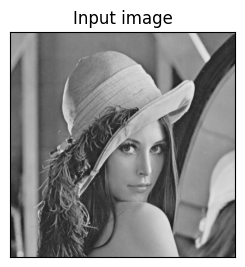

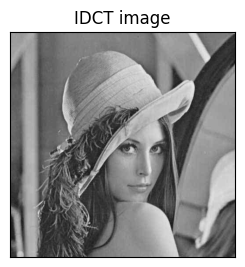

RMSE: 4.675
PSNR: 34.736


In [1192]:
plt.subplot(121),plt.imshow(adjusted_img, cmap = 'gray', clim=(0, 255))
plt.title('Input image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(IDCT, cmap = 'gray', clim=(0, 255))
plt.title('IDCT image'), plt.xticks([]), plt.yticks([])
plt.show()

print ("RMSE: %5.3f" % rmse(IDCT, adjusted_img))
print ("PSNR: %5.3f" % psnr(IDCT, adjusted_img))

**Compressão**

Como já vimos anteriormente, ao aplicar a codificação de Huffman, obtemos uma compressão de 5.843. Porém, além da sequência binária que representa a imagem codificada, também é necessário salvar um cabeçalho com mais algumas informações para a reconstrução da imagem.

Nesse sentido, o cabeçalho contém as informações essenciais, como o tamanho da imagem (altura e largura) e a tabela de símbolos da codificação de Huffman.

Por fim, armazenando tanto a sequência binária da imagem quanto o cabeçalho para sua posterior reconstrução, obtivemos uma taxa de compressão de 5.747. Essa taxa de compressão leva em consideração tanto a eficiência da codificação quanto o espaço necessário para os dados adicionais no cabeçalho, equilibrando a redução do tamanho do arquivo com a manutenção da capacidade de reconstrução da imagem.

In [1193]:
originalFile = IMAGE_PATH
compressedFile = IMAGE_PATH + '.bin'
statsOriginal = os.stat(originalFile)
statsCompressed = os.stat(compressedFile)
print("Taxa de Compressao: ",np.int64(statsOriginal.st_size)/np.int64(statsCompressed.st_size))

Taxa de Compressao:  5.746996931170539


#### Execução com outras imagens de teste

Nessa sessão, mostraremos os resultados obtidos com as outras imagens de teste fornecidas. Executamos o código acima trocando a imagem original e documentamos abaixo as métricas observadas.

**unequal.pgm**

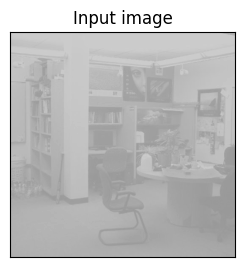

------ Resultados ------
RMSE: 2.45
PSNR: 40
Taxa de compressão: 6.74


In [1194]:
UNEQUAL_IMAGE_PATH = 'unequal.pgm'

unequal_img = cv2.imread(UNEQUAL_IMAGE_PATH, 0)

plt.subplot(121),plt.imshow(unequal_img, cmap = 'gray', clim=(0, 255))
plt.title('Input image'), plt.xticks([]), plt.yticks([])
plt.show()

print ("------ Resultados ------")
print ("RMSE: 2.45")
print ("PSNR: 40")
print ("Taxa de compressão: 6.74")

**cameraman.pgm**

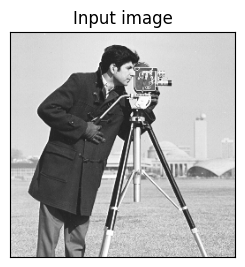

------ Resultados ------
RMSE: 8.115
PSNR: 30
Taxa de compressão: 4.56


In [1195]:
CAMERAMEN_IMAGE_PATH = 'cameraman.pgm'

cameramen_img = cv2.imread(CAMERAMEN_IMAGE_PATH, 0)

plt.subplot(121),plt.imshow(cameramen_img, cmap = 'gray', clim=(0, 255))
plt.title('Input image'), plt.xticks([]), plt.yticks([])
plt.show()

print ("------ Resultados ------")
print ("RMSE: 8.115")
print ("PSNR: 30")
print ("Taxa de compressão: 4.56")

#### Conclusão

Os resultados obtidos ao aplicar o processo de compressão com codificação de Huffman indicam uma performance eficiente na redução do tamanho das imagens, mantendo uma qualidade visual satisfatória. Para a imagem "lena512.pgm", observamos uma taxa de compressão de 5.747, um RMSE de 4.675 e um PSNR de 34.736 dB, o que sugere uma boa qualidade de reconstrução da imagem. As diferenças visuais entre a imagem original e a comprimida são mínimas, o que comprova a eficácia da compressão.

No entanto, ao testarmos imagens menores, notamos uma redução nas taxas de compressão e um PSNR inferior, o que é esperado devido à menor quantidade de dados para compressão. Além disso, imagens cujas dimensões não são múltiplas de 8x8 apresentaram distorções, com a geração de uma linha preta devido ao preenchimento (padding), o que impacta negativamente no resultado final. Embora a compressão continue eficaz, esses fatores devem ser considerados ao trabalhar com imagens de diferentes tamanhos.

Em suma, os resultados indicam que a codificação de Huffman é uma abordagem eficiente para compressão de imagens, oferecendo uma boa relação entre taxa de compressão e qualidade da reconstrução, com a necessidade de ajustar o processo para lidar com imagens menores ou com dimensões não múltiplas de 8.